In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
import nltk
import imageio
import sklearn

from timeit import default_timer as timer
%matplotlib inline

import json as js

# Project
### Stages

**Timetable**

| Time | Task |
|----|----|
|9.9. | Groups deadline |
|16.9.| Topics deadline |
| here | EDA, clean data, do project |
|vk42 | presentation |
|vk43 | projektit |

## Project
```
A. Title of the project	
            
B. Elevator pitch [max 400 characters]
 
Describe the data science challenges related to the following themes. 
A good project should include interesting challenges under most of 
the themes. So for example, a project that begins with a single clean
data set and a clear task (e.g., predict a given response), isn't a good 
choice for your project.		
            
C. Data: sources, wrangling, management		
            
D. Data analysis: statistics, machine learning	
            
E. Communication of results: summarization & visualization
            
F. Operationalization: creating added value, end-user point of view
```

- 4x20x10000 stuctures with 19-30 atoms in a cluster
    - coordinates
    - dipole moment
    - energy
- Goals
    - End user
        - Configuration Sampling 
            - Find one structure with the lowest energy
    - Eliminate redundant structures
    - Find descriptors
        - reduce dimensions
    

## Pitch talk 3min

- Sell oriented
    - Not technical
- Slides, picures, figures
    - Why useful
    - Why interesting
- Any person or all

> We could make video from screenshots describing the problem

> Check project-instructions for deadlines (tue 22.10. klo 23.59)

#### Read data in

Data must have a `.csv`-file that contains:

| col1 | col2 | col3 | col4 | col5 |
|------|------|------|------|------|
| Filename | path to .log-file | path to .xyz-file | Dipole moment | Energy |

Make the csv-file 
> Maybe later

Should read one sample xyz-file to construct headers and get shapes to an array

In [2]:
def init_DF(csvfile):
    "Reads a xyz-file and initializes the dataframe."
    
    filescsv = pd.read_csv(csvfile)
    xyz_temp = filescsv.iloc[0,2]  # to get one xyz(path) as a reference
    
    xyz_test = read_xyz(xyz_temp,False) # Read it to a DF
    
    #filenames = filescsv.iloc[:,0] # Take this one with init_xyz_flatrray()
    n_atoms = xyz_test.index.size
    atomnames = np.array(xyz_test.index)
    
    list_atomnames = []
    for i,j in enumerate(atomnames):
        list_atomnames.append("{}_{}".format(j,i))
    arr_atomnames = np.array(list_atomnames)
    
    col_names = makeMultiIndexs(arr_atomnames)

    arr_clusters,filenames = init_xyz_array(filescsv,n_atoms) # to have the actual data
    
    coord_df = pd.DataFrame(arr_clusters,index=filenames,columns=col_names)
    
    
    return coord_df

In [3]:
def init_xyz_array(filecsv, n_atoms):
    "Reads paths from .csv and returns an array with all coords in rows, and the filenames for DF indexes"
    arr_clusters = np.zeros((1,3*n_atoms+2))
    filenames = np.array(filecsv.Filename)
    for index, row in filecsv.iterrows():
        #filename = row.Filename
        dipole = row.Dipole
        energy = row.Energy
        metarr = np.array([energy,dipole])
        path = row.XYZPath
        xyzs = read_xyz(path) #flatten=True by default

        if index == None:
            print("Filename:",filename)
            print("metarr:",metarr)
            print("shape:",metarr.shape)
            print("type:",type(metarr))
            print("path:",path)
            print("coordshape:",xyzs.shape)
            print("coords:",xyzs)
        
        arrr = np.array(list(metarr)+list(xyzs))
        arr_clusters = np.vstack((arr_clusters,arrr))
    return arr_clusters[1:,:], filenames

In [8]:
def read_xyz(xyzfile,flatten=True):
    """
    usage: read_xyz(xyzfile,flatten(Default=True))
    
    Reads a xyz-file and returns the coordinates as DF
    or flattened to a Numpy-array
    """
    xyz_temp = pd.read_csv(xyzfile, \
                       sep='\s+', \
                       skiprows=2, \
                       header=None, \
                       index_col=0, \
                       names=['x','y','z']\
                      ).sort_index(ascending=False)
    
    atoms3 = xyz_temp.shape[0]*3
    
    if flatten==True:
        xyz_flat = xyz_temp.values.flatten().reshape(1,atoms3)#.astype(np.float)
        return xyz_flat[0]
    else:
        return xyz_temp

In [5]:
def makeMultiIndexs(arr):
    """
    Gets names of atoms as array and makes a pandas multi-indexing structure
    with x-, y- and z- columns for each atom.
    """
    top_arr = np.empty((arr.size * 3 +2)).astype(str)
    top_arr[0] = "Properties"
    top_arr[1] = "Properties"
    top_arr[2::3] = arr
    top_arr[3::3] = arr
    top_arr[4::3] = arr
    butt_arr = np.empty((arr.size * 3 +2)).astype(str)
    butt_arr[0] = "Energy"
    butt_arr[1] = "Dipole"
    butt_arr[2::3] = "x"
    butt_arr[3::3] = "y"
    butt_arr[4::3] = "z"
    col_arr = np.vstack((top_arr,butt_arr))
    #col_arr.transpose()
    col_arr_tuples = list(zip(*col_arr))
    col_names = pd.MultiIndex.from_tuples(col_arr_tuples, names=["Atom","Coord"])
    return col_names

In [9]:
clusters_df = init_DF("Data2/Data_Collection.csv")

In [19]:
#from multi-index to one index
clusters_df.columns = ['_'.join(col) for col in clusters_df.columns.values]

NameError: name 'clusters_df' is not defined

In [10]:
clusters_df.shape

(2000, 59)

## Data exploration

We start by looking at the correlation among our variables. The correlation betwwen two variables is a measure of the linear dependecy among them:
$$ Cor(X,Y)=\frac{Cov(X,Y)}{\sqrt{Var(X)Var(Y)}}$$
In order to apply a linear model to predict the energy wrt the other variables, is important to check that there is a small correlation  between the variables we are using as predictors, since we will predict the response by an approprate linear combination of the predictors. In our data, there is no particoularly high correlation.

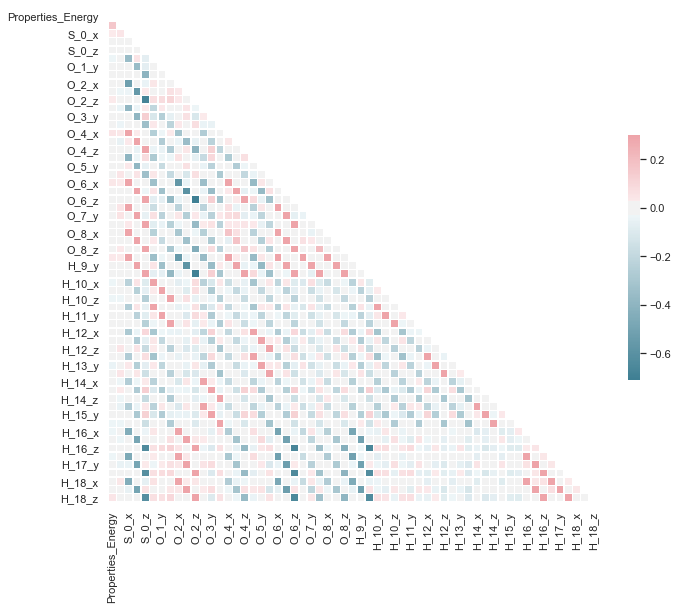

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = clusters_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The correlations among data are not really high, hence we can consider all of hem as independent variables.   
Having a look on the distributions of the energy variable, it is asymmetric, with a tail on the right. 

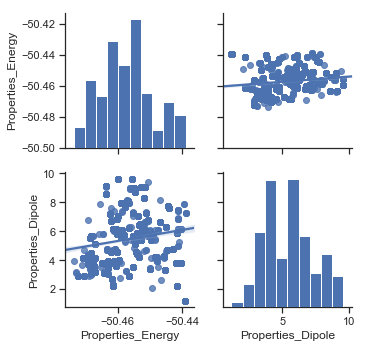

In [13]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
sns.pairplot(clusters_df,  kind="reg",vars=['Properties_Energy','Properties_Dipole'])

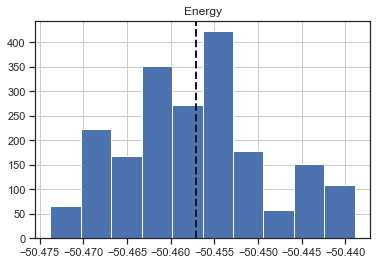

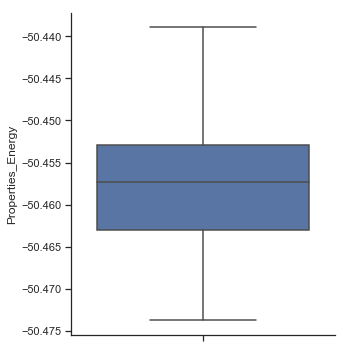

In [14]:

clusters_df['Properties_Energy'].hist()
plt.title("Energy")
plt.axvline(np.mean(clusters_df['Properties_Energy']), color='k', linestyle='dashed', linewidth=2)

sns.catplot( y="Properties_Energy", kind="box", data=clusters_df)
plt.show()

## Linear regression

In statistics we define as "supervised learning" the set of models that are ment to evaluate an output $y$ (answer variable) as a function of a set of known indipendent variables taken as input $(X_1,...,X_k)$ .   
Furthermore, if we assume that $Y$ has a known probability law, we use parametric models. When $Y$ is a continuous variable, the mainly used model is the regression, that is a method that allows to estimate the conditional average of the answer $ E (Y | X_1 = x_1, ..., X_k = x_k) $ or its transformed as a linear combination of the explanatory $\eta=X '\beta $.
We have a simple linear regression, when using a model of the type:
$$ Y_i = x_i '\beta + \varepsilon_i $$ with $i = 1, ..., n $ number of observations, such that $ n> k $. Equivalently, in compact form:
$$ Y = X \beta + \varepsilon $$ where $ Y_ {nx1} = (Y_1, ..., Y_n) '$ is the vector of n v.c. of independent outputs, $ X_ {nx (k + 1)} $ is the matrix of the drawing, which together with the vector of coefficients $ \beta = (\beta_0, ..., \beta_k) '$ constitutes the deterministic component of the model, while $ \varepsilon = (\varepsilon_1, ..., \varepsilon_n) '$ is the erratic component, where $ \varepsilon_i \sim N (0, \sigma ^ 2 _ {\varepsilon}) $ for each $ i $ are unknown errors with zero mean and constant variance.

We can implement a linear regression model to predict the energy ($y$) of our cluster with rrespect to the coordinates variables ($X$). As we saw above, our response takes all values around -40.9, what makes the difference is the centesimal portion, hence we will focus our attention on predicting this part.


In [24]:
clusters_df.head(5)

,Properties_Energy,Properties_Dipole,S_0_x,S_0_y,S_0_z,O_1_x,O_1_y,O_1_z,O_2_x,O_2_y,...,H_15_z,H_16_x,H_16_y,H_16_z,H_17_x,H_17_y,H_17_z,H_18_x,H_18_y,H_18_z
0,-50.454068,5.877,0.141169,0.586462,-1.579178,1.571959,0.634674,1.587390,-0.496376,-0.793090,...,-0.603801,0.369601,-0.238477,1.922843,-1.215370,-0.160903,1.456282,-0.303001,-1.543416,1.207911
1000,-50.461636,2.250,-0.310743,-0.693484,-0.873397,2.268091,0.183939,1.253796,0.159254,-0.640969,...,2.016578,-0.114822,-1.212266,1.515452,1.082611,-0.271578,2.080668,-0.496781,0.156998,2.301243
1001,-50.452717,9.048,1.431612,0.005407,-0.786148,0.709225,-1.650772,1.562096,-0.343273,0.644171,...,-1.552913,-1.327175,0.532181,1.468793,0.050890,-0.308596,1.884421,0.173034,1.035303,0.963940
1002,-50.464589,5.825,-0.476055,-1.254348,-0.638647,-0.435816,1.721100,0.908611,1.835372,0.709726,...,-2.162444,0.941051,1.250367,0.948890,1.453065,-0.265028,0.613779,2.056392,0.967905,-0.221780
1003,-50.464589,5.822,1.359544,-0.557122,-0.222733,-1.232580,1.088127,1.126452,-1.917789,-0.360538,...,-1.780735,-1.064533,-0.973091,-0.696218,-1.811289,0.253754,0.083011,-1.659970,0.250304,-1.551019


In [47]:
energy=clusters_df['Properties_Energy']%1
coord=clusters_df.drop(['Properties_Energy','Properties_Dipole'],1) #dipole? in or out?

In [48]:
#divide the dataset in train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(coord,energy,test_size=0.20)

In [49]:
#linear regression model on train set
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [50]:
model = LinearRegression()
model.fit(x_train, y_train)
#model.coeff
r_sq = model.score(x_train, y_train)
r_sq #pretty bad

0.03090492098553388

In [52]:
#predict from the test
y_pred = model.predict(x_test)
pred_test = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred.flatten()})
pred_test.head(6)

,Actual,Predicted
0,0.560888,0.545631
1,0.539788,0.542316
2,0.539785,0.541338
3,0.544860,0.541297
4,0.539461,0.541468
5,0.537997,0.543519


In [53]:
#feature selection alternative
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(x_train, y_train)
print(selector.support_) 
print(selector.ranking_)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True]
[53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30
 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6
  5  4  3  2  1  1  1  1  1]


In [54]:
#oxigen O8 seems the most significant variable in our model
model1 = LinearRegression().fit(x_train.loc[:,('H_17_x','H_17_y','H_17_z','H_18_x','H_18_y','H_18_z')], y_train) #select the most significant variables...
print('R2 simple reg',model1.score(x_train.loc[:,('H_17_x','H_17_y','H_17_z','H_18_x','H_18_y','H_18_z')], y_train))

R2 simple reg 0.003388301644372982


In [55]:
x_train.shape

(1600, 57)

## Principal Component Analysis
The PCA is a tool used to reduce the dimensionality of the data avoiding loss of relevant information contained in the data.
These two goals in PCA are pursued by means of a transformation of the original variables into new variables, called Principal Components (PCs). They consists of a linear combination of the original ones, so that they are uncorrelated and arranged in order of decreasing variance, so that the firts PCs account for much of the variation in the sample.   

Assuming we want to reduce the number of our original p variables to $k<p$ variables, the PCA method can be formalized as follows
• 1st PC: determine the coeffcients of the linear combination
$$Z_{1j}=a_1^TX=\sum_{i=0}^p a_{1i}X_i $$ 
that maximize $Var(Z1) = a1^T \Sigma a1$ under the constraint $ a_1^T a_1=1$   

• 2nd PC: determine coeffcients of the linear combination
$$Z_{2j}=a_2^TX=\sum_{i=0}^p a_{2i}X_i $$
that maximize $Var(Z2) = a2^T \Sigma a2$ under the constraint $ a_2^T a_2=1$ and $Cov(Z_1,Z_2)=0$   

• proceed in a similar fashion for all other components.   

• Final output: $Z_1, \dots ,Z_p $such that $Var (Z1) > Var (Z2) > \dots > Var (Zp)$ and $cov(Zj ; Zk ) = 0$ for $j \neq k$  

We will apply PCA to our coordinates variable, in order to select new variables, that explain at least 80% of the variability of our data.

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=11)
principalComponents = pca.fit_transform(coord)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11'])
print('Explained variance :', np.sum(pca.explained_variance_ratio_)*100, '%')

Explained variance : 84.08258800049938 %


Explained variance PC1 : 13.187808276152863 %
Explained variance PC2 : 10.909793397790143 %


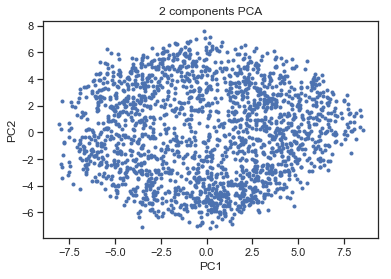

In [57]:
#2D graph of first two PCs
print('Explained variance PC1 :', pca.explained_variance_ratio_[0]*100, '%')
print('Explained variance PC2 :', pca.explained_variance_ratio_[1]*100, '%')

plt.plot(principalDf['PC1'] , principalDf['PC2'], '.')
plt.title("2 components PCA")
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

## K-means
In order to reduce the variety of our observations we are clustering our data, by using a k-mean algorith.  
This algorithm is a non-hierarchical methods of clustering, i.e. we assume the number $k$ of groups is assumed to be fixed.
Algorithm introduced by MacQueen (1967): each statistical unit is assigned to the cluster whose centroid (i.e. vector of means) is the closest one. The metric used to measure the distance among groups is typically the Euclidean one.
1. Initial partition into K clusters, (possibly randomly generated)
2. For each of the K clusters, compute the cluster centroid.
3. Assign each observation to the cluster whose centroid is closest
4. Recompute centroids for all clusters
5. Repeat 3. - 4. until reaching a maximum number of iterations or when it is not possible to redistribute observations

In order to chose the optimal number of groups, a good criteria is to find a balance between low within-cluster variation $WSS$ and number of groups.  
We start by clustering our original dataset, a clustering of the PCs dtaset is also shown.

In [58]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)  #we should chose the number of clusters
kmeans.fit(clusters_df)
y_kmeans = kmeans.predict(clusters_df)

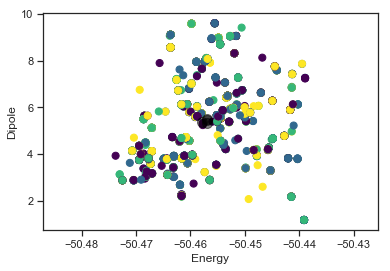

In [59]:
plt.scatter(clusters_df['Properties_Energy'], clusters_df['Properties_Dipole'], c=y_kmeans,s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.xlabel('Energy')
plt.ylabel('Dipole')
plt.show()

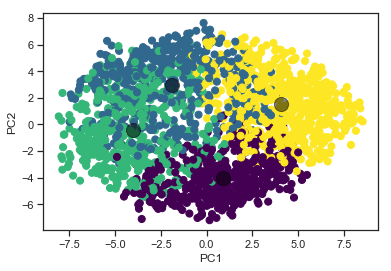

In [60]:
#clustering using PCS as variables
finalDf = pd.concat([principalDf, clusters_df[['Properties_Energy']]], axis = 1)
finalDf = pd.concat([finalDf, clusters_df[['Properties_Dipole']]], axis = 1)
kmeans.fit(finalDf)
y_kmeans = kmeans.predict(finalDf)
plt.scatter(finalDf['PC1'], finalDf['PC2'], c=y_kmeans,s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

***

***

***

***

***

***

***

***

***

***

***

***

***

***

***

In [61]:
files = pd.read_csv("Data_Collection.csv")
np.array(files.Filename)

array([ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  1, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  2, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  3,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  4,  5,  6,  7,  8,  9])

In [62]:
test = next(files.iterrows())[1]
print(test)
type(test.Filename)

Filename                      0
LogPath      ./Data1/logs/0.log
XYZPath     ./Data1/coord/0.xyz
Dipole                    2.402
Energy                 -40.9179
Name: 0, dtype: object


int

In [63]:
xyz_test = pd.read_csv("Data1/coord/0.xyz", \
                       sep='\s+', \
                       skiprows=2, \
                       header=None, \
                       index_col=0, \
                       names=['x','y','z']\
                      ).sort_index(ascending=False)
# Atom names in indexes

```python
xyz_test = pd.read_csv("Data1/0.xyz", \
                       sep='\s+',\
                       skiprows=2, \
                       header=None, \
                       names=['atom','x','y','z']\
                      ).sort_values(by='atom',ascending=False).reset_index(drop=True)
# Atom names in col 0
```


Print the names of the atoms

> How is order handled under one label?
- what is the order of other coord files?

Save the names of the atoms to an array

In [30]:
arr_indexes = np.array(xyz_test.index)

In [31]:
arr_indexes.shape[0]

19

Get numbers for the atoms and concatenate them with the labels

In [32]:
list_atomnames = []

for i,j in enumerate(arr_indexes):
    list_atomnames.append("{} {}".format(j,i))

arr_atomnames = np.array(list_atomnames)

Make the multi-index array of tuples

In [33]:
top_arr = np.empty((arr_atomnames.size * 3)).astype(str)
top_arr[0::3] = arr_atomnames
top_arr[1::3] = arr_atomnames
top_arr[2::3] = arr_atomnames
#top_arr

In [34]:
butt_arr = np.empty((arr_atomnames.size * 3)).astype(str)
butt_arr[0::3] = "x"
butt_arr[1::3] = "y"
butt_arr[2::3] = "z"
#butt_arr

In [35]:
col_arr = np.vstack((top_arr,butt_arr))
#col_arr.transpose()
col_arr_tuples = list(zip(*col_arr))
col_arr_tuples[:5]

[('S 0', 'x'), ('S 0', 'y'), ('S 0', 'z'), ('O 1', 'x'), ('O 1', 'y')]

Multi-index column names

In [17]:
col_names = pd.MultiIndex.from_tuples(col_arr_tuples, names=["Atom","Coord"])
col_names

MultiIndex(levels=[['H 10', 'H 11', 'H 12', 'H 13', 'H 14', 'H 15', 'H 16', 'H 17', 'H 18', 'H 9', 'O 1', 'O 2', 'O 3', 'O 4', 'O 5', 'O 6', 'O 7', 'O 8', 'S 0'], ['x', 'y', 'z']],
           labels=[[18, 18, 18, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 9, 9, 9, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8], [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=['Atom', 'Coord'])

In [18]:
3*19

57

In [19]:
xyz_test.values.flatten().shape

(57,)

In [20]:
xyz_flat = xyz_test.values.flatten().reshape(1,57)

In [21]:
type(xyz_flat)

numpy.ndarray

In [23]:
coord_df = pd.DataFrame(xyz_flat,index=['a'],columns=col_names)
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(coord_df)

Atom        S 0                           O 1                          O 2  \
Coord         x         y         z         x         y        z         x   
a      0.141169  0.586462 -1.579178  1.571959  0.634674  1.58739 -0.496376   

Atom                           O 3                          O 4            \
Coord        y         z         x         y         z        x         y   
a     -0.79309  1.912224  0.122061 -2.393288  0.079677  1.01335 -0.572018   

Atom                  O 5                          O 6                      \
Coord         z         x         y        z         x         y         z   
a     -1.481227 -1.989939  0.798705  0.68009  0.522933  1.346199 -2.915277   

Atom        O 7                           O 8                          H 9  \
Coord         x         y         z         x        y         z         x   
a      0.369189  1.535905 -0.499852 -1.256258  0.20951 -1.702193  0.192515   

Atom                           H 10                          H 

In [24]:
coord_df

Atom        S 0                           O 1                          O 2  \
Coord         x         y         z         x         y        z         x   
a      0.141169  0.586462 -1.579178  1.571959  0.634674  1.58739 -0.496376   

Atom                           O 3    ...         H 15      H 16            \
Coord        y         z         x    ...            z         x         y   
a     -0.79309  1.912224  0.122061    ...    -0.603801  0.369601 -0.238477   

Atom                H 17                          H 18                      
Coord         z        x         y         z         x         y         z  
a      1.922843 -1.21537 -0.160903  1.456282 -0.303001 -1.543416  1.207911  

[1 rows x 57 columns]